# 🔬 Wisconsin Breast Cancer Classification

## Introduction

This notebook focuses on classifying breast cancer tumors as **malignant** or **benign** based on features extracted from digitized images of fine needle aspirate (FNA) of breast mass. This is a binary classification problem where:

- **Malignant**: Cancerous tumor (class 0)
- **Benign**: Non-cancerous tumor (class 1)

We'll explore the dataset, visualize key features, preprocess the data, and implement multiple machine learning models to solve this important medical classification problem.

## 📊 Data Loading and Understanding

First, we'll import the necessary libraries and load the Wisconsin Breast Cancer dataset which is available in scikit-learn. This dataset contains features computed from digitized images of FNA of breast masses.

In [55]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set style for plots
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Load the Wisconsin Breast Cancer dataset
data = load_breast_cancer()

# Create a pandas DataFrame
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Check the shape of the data
print(f"Dataset shape: {X.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Display target distribution
target_counts = pd.Series(data.target).value_counts()
print(f"\nTarget distribution:\n{target_counts}")
print(f"Target names: {data.target_names}")

# Preview the first few rows of the dataset
X.head()

Dataset shape: (569, 30)
Features: 30
Samples: 569

Target distribution:
1    357
0    212
Name: count, dtype: int64
Target names: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Understanding the Features

Let's explore the dataset's features and see how they relate to the target variable. We'll first look at basic statistical information and then visualize feature distributions.

In [56]:
# Basic statistics of the features
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [57]:
# Create a DataFrame combining features and target for analysis
df = pd.concat([X, y], axis=1)

# Check for missing values
print("Missing values in dataset:")
print(df.isnull().sum().sum())

Missing values in dataset:
0


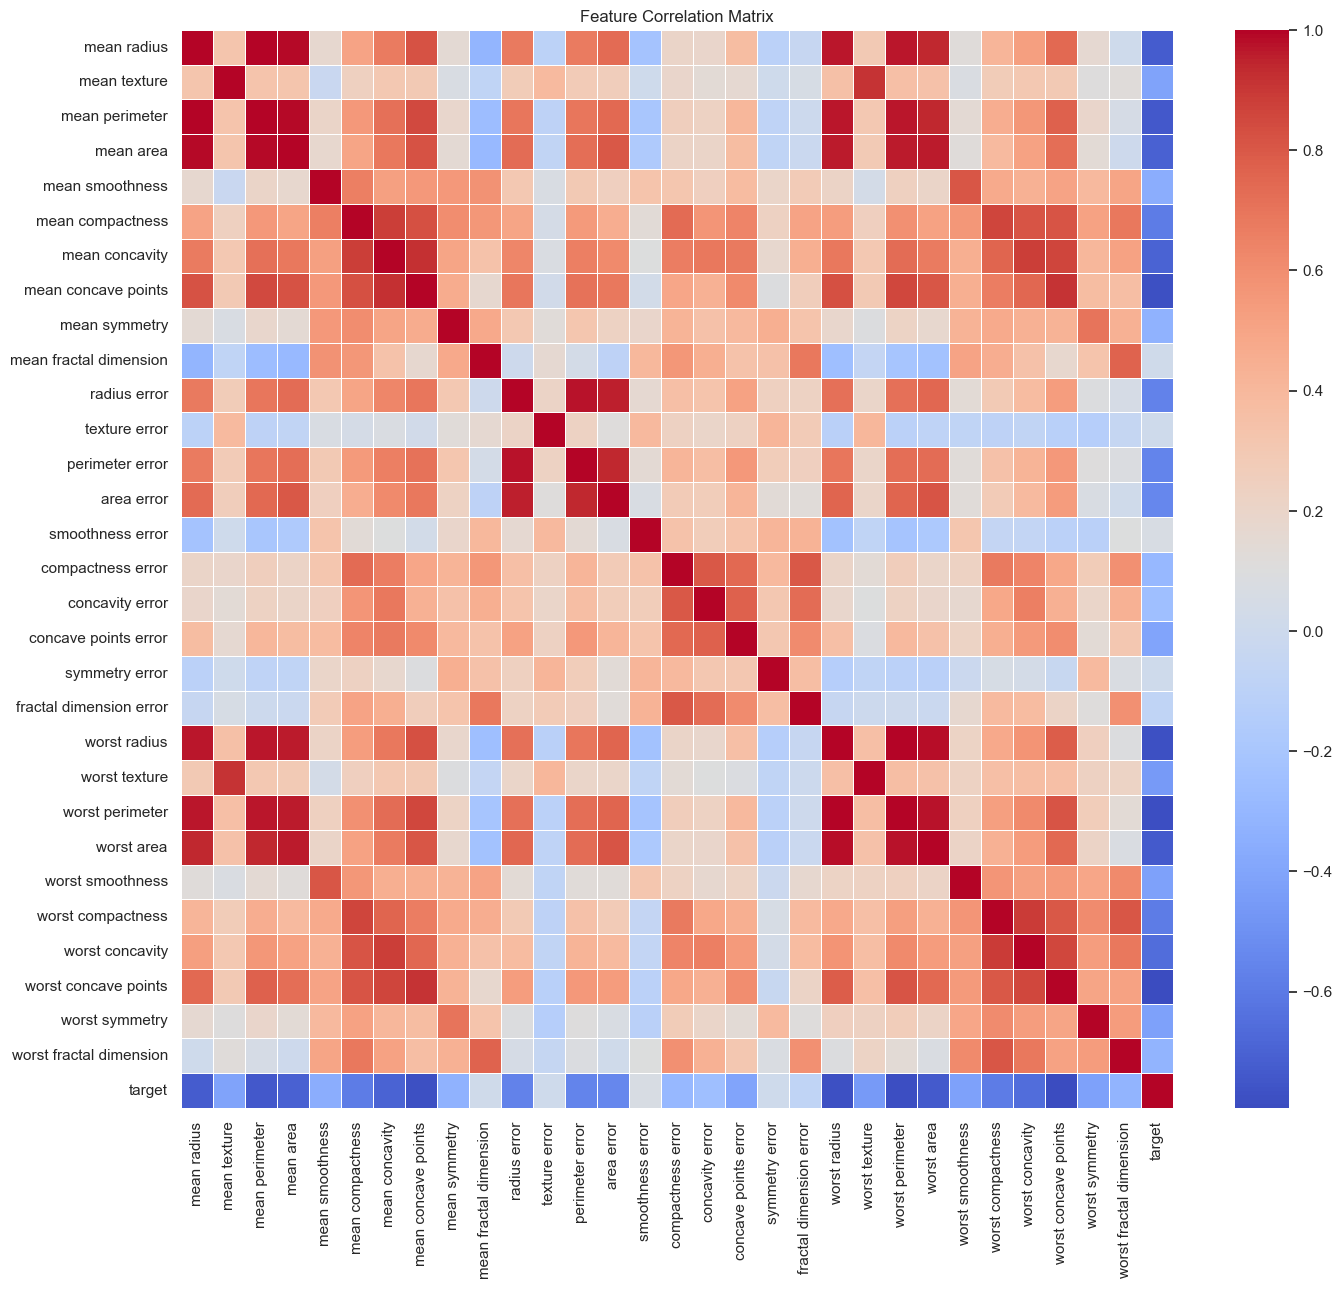

In [58]:
# Visualize correlations between features
plt.figure(figsize=(16, 14))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

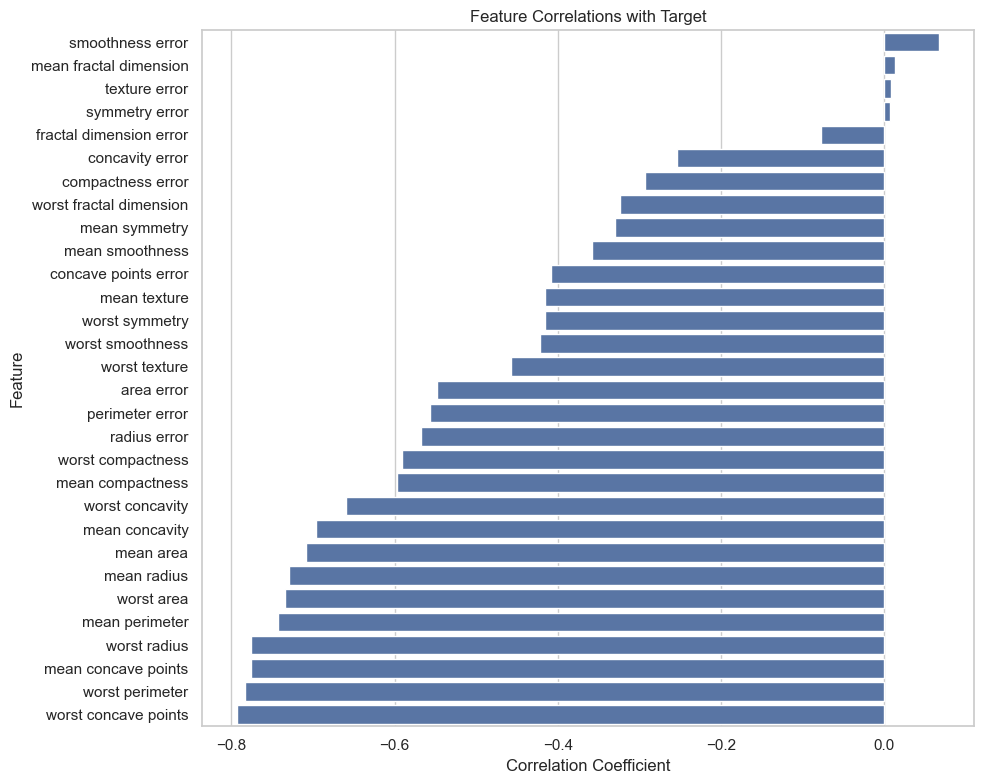

In [42]:
# Visualize correlation with target
plt.figure(figsize=(10, 8))
# Sort correlations with target
target_corr = correlation_matrix['target'].sort_values(ascending=False)
# Exclude target self-correlation
target_corr = target_corr[target_corr.index != 'target']
# Plot top correlations
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Feature Distribution by Target Class

Let's visualize how the distributions of key features differ between malignant and benign tumors.

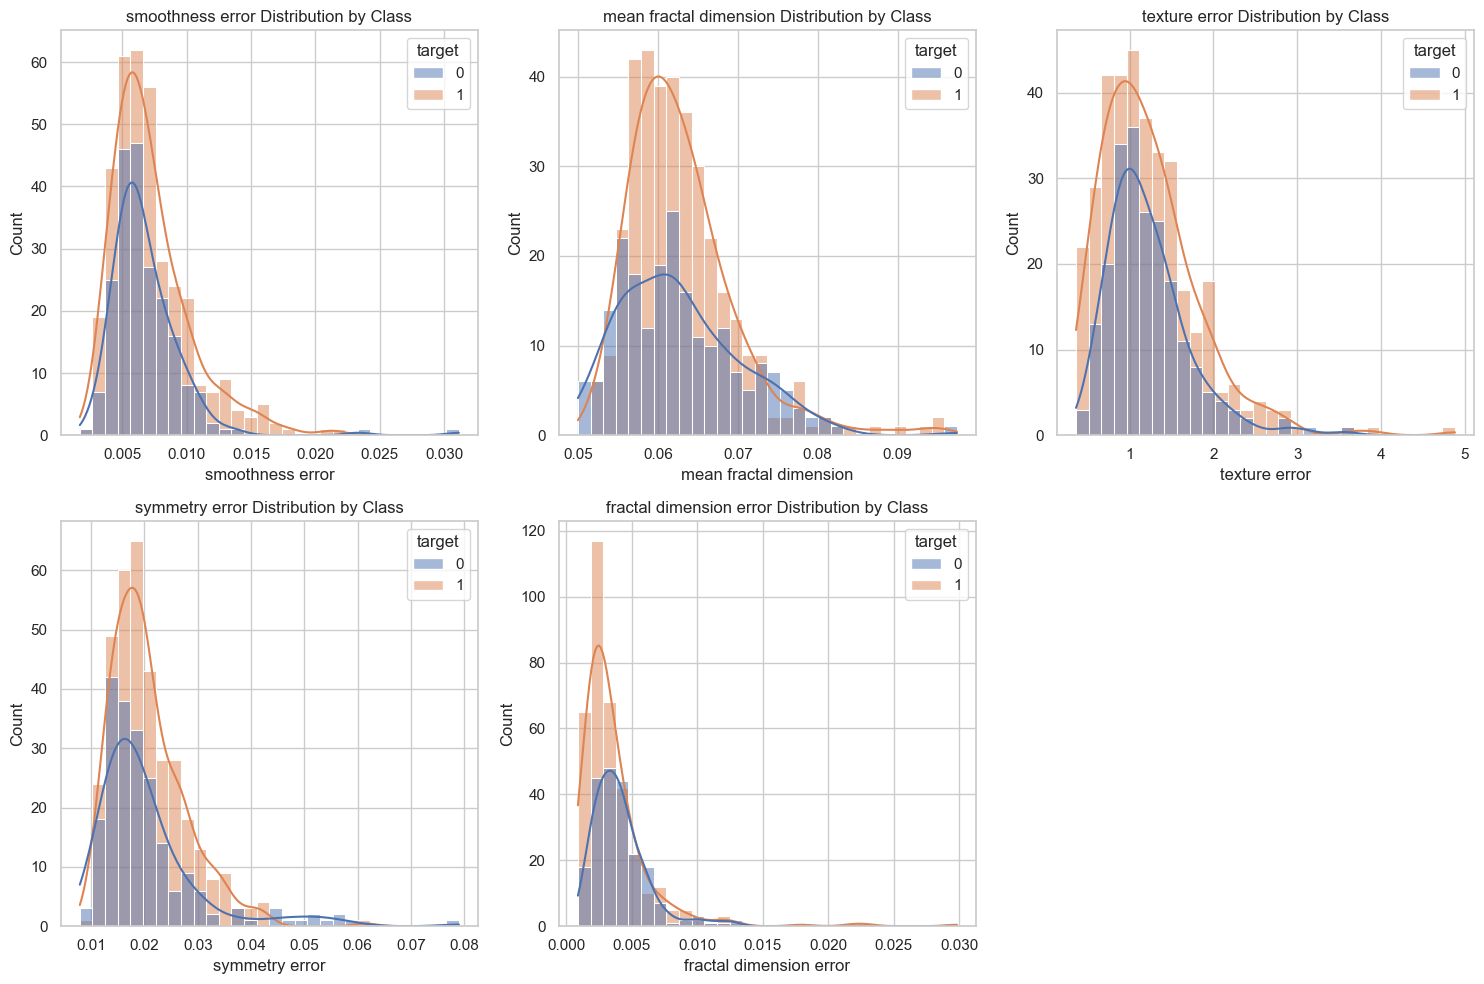

In [43]:
# Select a few important features based on correlation
top_features = target_corr.index[:5]

# Create pair plots to visualize relationships
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=feature, hue='target', kde=True, bins=30)
    plt.title(f"{feature} Distribution by Class")

plt.tight_layout()
plt.show()

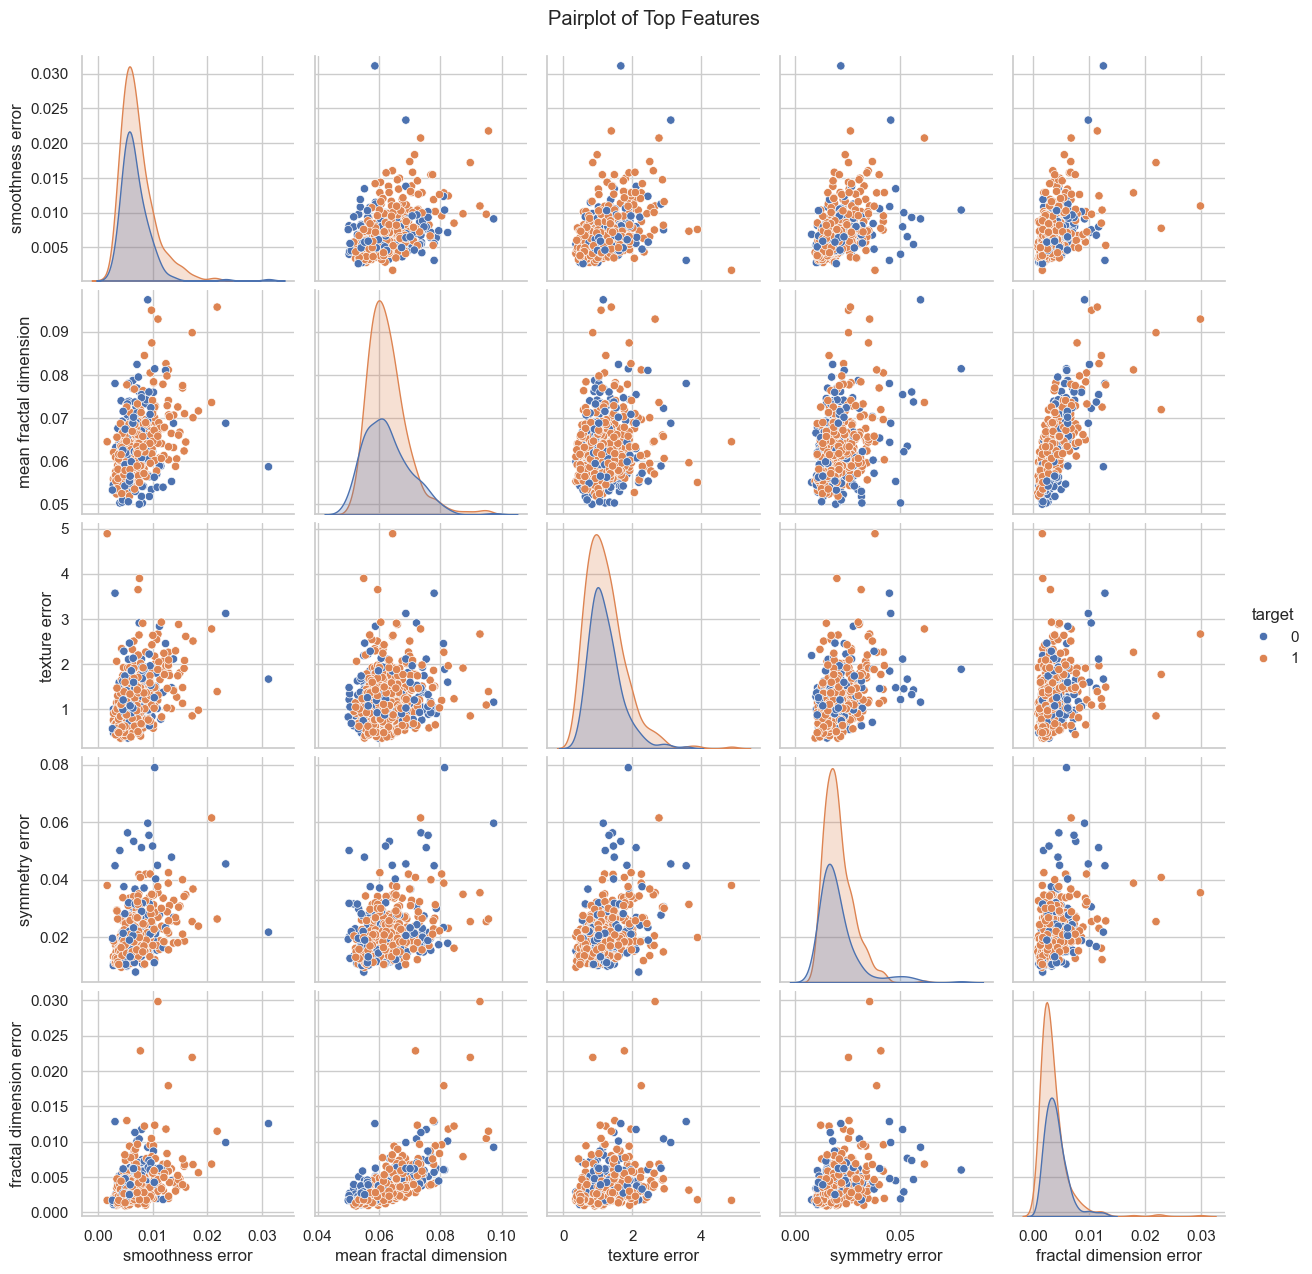

In [44]:
# Create a pairplot for the top correlated features
subset_df = df[list(top_features) + ['target']]
sns.pairplot(subset_df, hue='target', diag_kind='kde')
plt.suptitle('Pairplot of Top Features', y=1.02)
plt.show()

## Data Preprocessing

Now that we understand our data, let's prepare it for modeling. We need to:
1. Split the data into training and testing sets
2. Scale the features to standardize their ranges

In [45]:
# Split the data into features (X) and target (y)
X = data.data
y = data.target

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of our splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (455, 30)
X_test shape: (114, 30)
y_train shape: (455,)
y_test shape: (114,)


In [46]:
# Scale the features
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test)

# Check the mean and standard deviation of the scaled data
print("Training data mean after scaling:", X_train_scaled.mean(axis=0)[:5], "...")
print("Training data std after scaling:", X_train_scaled.std(axis=0)[:5], "...")

Training data mean after scaling: [-4.31742554e-15  2.24606658e-15 -7.38359313e-16  1.71779562e-16
  5.22695440e-15] ...
Training data std after scaling: [1. 1. 1. 1. 1.] ...


## 🧠 Model Development: Neural Network

Now we'll build a feedforward neural network using TensorFlow and Keras to classify the tumors. We'll configure the model architecture to achieve optimal performance for this binary classification task.

In [47]:
# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [48]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Build a neural network model with flexible architecture
def build_nn_model(layer_sizes=[64, 32, 16], activations=['relu', 'relu', 'relu'], 
                   output_activation='sigmoid', name_prefix='model'):
    """
    Build a flexible neural network model
    
    Parameters:
    - layer_sizes: list of integers defining the number of neurons in each hidden layer
    - activations: list of activation functions for each hidden layer
    - output_activation: activation function for the output layer
    - name_prefix: prefix for layer names to ensure uniqueness
    
    Returns:
    - Compiled Keras Sequential model
    """
    # Input validation
    if len(layer_sizes) != len(activations):
        raise ValueError("Number of layer sizes must match number of activation functions")
    
    # Build model
    layers = []
    
    # Input layer
    layers.append(Dense(layer_sizes[0], activation=activations[0], 
                        input_shape=(30,), name=f"{name_prefix}_input_layer"))
    layers.append(Dropout(0.3, name=f"{name_prefix}_dropout_1"))  # Increase dropout for better regularization
    
    # Hidden layers
    for i in range(1, len(layer_sizes)):
        layers.append(Dense(layer_sizes[i], activation=activations[i], 
                           name=f"{name_prefix}_hidden_layer_{i}"))
        if i < len(layer_sizes) - 1:  # Add dropout after all but the last hidden layer
            layers.append(Dropout(0.3, name=f"{name_prefix}_dropout_{i+1}"))
    
    # Output layer - binary classification
    layers.append(Dense(1, activation=output_activation, name=f"{name_prefix}_output"))
    
    model = Sequential(layers)
    
    # Compile the model with better optimizer settings
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model with optimized parameters
nn_model = build_nn_model(
    layer_sizes=[64, 32, 16],
    activations=['relu', 'relu', 'relu'],  # ReLU generally performs better than sigmoid for hidden layers
    output_activation='sigmoid',  # For binary classification, sigmoid is appropriate for output layer
    name_prefix='nn'  # Add a prefix to ensure unique layer names
)

# Display the model summary
nn_model.summary()

c:\personal\Holberton\holbertonschool-machine_learning\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nn_input_layer (Dense)          │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_dropout_1 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_hidden_layer_1 (Dense)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_dropout_2 (Dropout)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_hidden_layer_2 (Dense)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nn_output (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Set up early stopping to prevent overfitting with improved configuration
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss to detect overfitting
    patience=15,              # Wait 15 epochs before stopping if no improvement
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1,                # Show messages when early stopping is triggered
    min_delta=0.001           # Minimum change to qualify as an improvement
)

# Record start time for model training
start_time = time.time()

# Train the model with validation data to monitor for overfitting
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,               # Maximum number of epochs
    batch_size=16,            # Process 16 samples before updating weights
    validation_split=0.2,      # Use 20% of training data for validation
    callbacks=[early_stopping], # Use early stopping to prevent overfitting
    verbose=1                  # Show training progress
)

# Calculate training time
nn_training_time = time.time() - start_time
print(f"\n⏱️ Neural Network training time: {nn_training_time:.2f} seconds")

# Check if early stopping was triggered and when
epochs_completed = len(history.history['loss'])
max_possible_epochs = 100
if epochs_completed < max_possible_epochs:
    print(f"✅ Early stopping activated after {epochs_completed} epochs")
    print(f"🔍 Best model restored from epoch {np.argmin(history.history['val_loss'])+1}")
else:
    print("⚠️ Maximum epochs reached without early stopping")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6096 - loss: 0.6819 - val_accuracy: 0.9121 - val_loss: 0.4273
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6096 - loss: 0.6819 - val_accuracy: 0.9121 - val_loss: 0.4273
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9076 - loss: 0.3584 - val_accuracy: 0.9451 - val_loss: 0.2498
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9076 - loss: 0.3584 - val_accuracy: 0.9451 - val_loss: 0.2498
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9181 - loss: 0.2434 - val_accuracy: 0.9670 - val_loss: 0.1648
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9181 - loss: 0.2434 - val_accuracy: 0.9670 - val_loss: 0.1648
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9480 - loss: 0.1689 - val_accuracy: 0.9670 - val_loss: 0.1193
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9480 - loss: 0.1689 - val_accuracy: 0.9670 -

### 📈 Visualize Training Process & Overfitting Check

Let's visualize the learning process and check for signs of overfitting by comparing training and validation metrics:

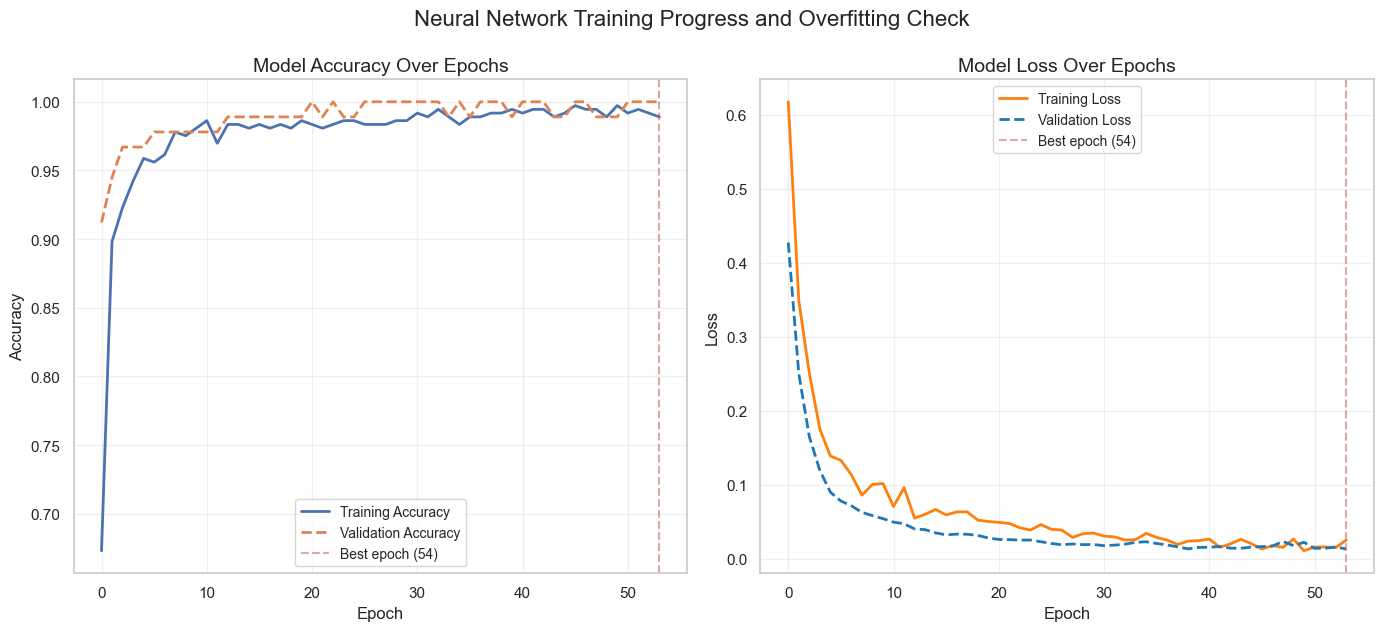


📊 Final Training Metrics:
   Training Accuracy: 0.9890
   Validation Accuracy: 1.0000
   Training Loss: 0.0249
   Validation Loss: 0.0131

🔍 Overfitting Analysis:
   ✅ No significant overfitting detected.
   - Model generalizes well between training and validation data.


In [50]:
# Plot training history with enhanced visualization
plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add reference line for best epoch if early stopping was triggered
best_epoch = np.argmin(history.history['val_loss'])
if len(history.history['loss']) < 100:  # If early stopping was triggered
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, 
                label=f'Best epoch ({best_epoch+1})')
    plt.legend(fontsize=10)

# Plot loss with overfitting check
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#1f77b4', linewidth=2, linestyle='--')
plt.title('Model Loss Over Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add reference line for best epoch if early stopping was triggered
if len(history.history['loss']) < 100:  # If early stopping was triggered
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, 
                label=f'Best epoch ({best_epoch+1})')
    plt.legend(fontsize=10)

plt.tight_layout()
plt.suptitle('Neural Network Training Progress and Overfitting Check', fontsize=16, y=1.05)
plt.show()

# Analyze overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Calculate the gap between training and validation metrics
loss_gap = final_train_loss - final_val_loss
acc_gap = final_train_acc - final_val_acc

print("\n📊 Final Training Metrics:")
print(f"   Training Accuracy: {final_train_acc:.4f}")
print(f"   Validation Accuracy: {final_val_acc:.4f}")
print(f"   Training Loss: {final_train_loss:.4f}")
print(f"   Validation Loss: {final_val_loss:.4f}")

print("\n🔍 Overfitting Analysis:")
if loss_gap < -0.05 or acc_gap > 0.05:
    print("   ⚠️ Some signs of overfitting detected.")
    if loss_gap < -0.05:
        print(f"   - Validation loss higher than training loss by {abs(loss_gap):.4f}")
    if acc_gap > 0.05:
        print(f"   - Training accuracy higher than validation accuracy by {acc_gap:.4f}")
    print("   - Early stopping helped prevent further overfitting.")
else:
    print("   ✅ No significant overfitting detected.")
    print("   - Model generalizes well between training and validation data.")

## 📊 Model Evaluation

Now we'll evaluate our neural network's performance on the test set. We'll examine various metrics including accuracy, precision, recall, and the confusion matrix to get a comprehensive understanding of the model's effectiveness.

In [51]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions with the neural network
y_pred_nn_prob = nn_model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).flatten()

# Calculate metrics
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)

# Print results
print("Neural Network Performance:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1 Score: {nn_f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['Malignant', 'Benign']))

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002729A8EBD90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002729A8EBD90> triggered tf.function retracing. Tracin

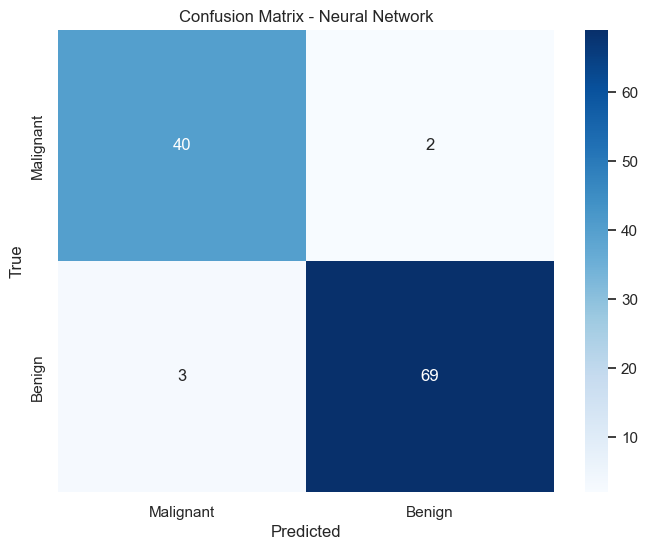

In [52]:
# Create and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Neural Network')
plt.show()

### 📝 Understanding the Evaluation Metrics

In the context of breast cancer classification, each metric has an important interpretation:

- **Accuracy**: The overall proportion of correct predictions.
  - Formula: $(TP + TN) / (TP + TN + FP + FN)$
  - Interpretation: "How many tumor diagnoses (both malignant and benign) did we get right?"

- **Precision**: When we predict a tumor is benign, how often are we correct?
  - Formula: $TP / (TP + FP)$
  - Interpretation: "When we tell a patient their tumor is benign, what's the probability we're right?"

- **Recall (Sensitivity)**: Of all the actual benign tumors, how many did we correctly identify?
  - Formula: $TP / (TP + FN)$
  - Interpretation: "What proportion of benign tumors did we correctly detect?"

- **F1 Score**: The harmonic mean of precision and recall, providing a balance between them.
  - Formula: $2 \times (Precision \times Recall) / (Precision + Recall)$

**Medical Context**: In cancer screening, we usually prioritize high recall (sensitivity) to ensure we don't miss actual cancer cases, as false negatives (missing a cancer diagnosis) are typically more harmful than false positives (which can be corrected with further testing).

## 🔄 Comparison with Simpler Models

Next, we'll compare our neural network with simpler models: Decision Tree and Logistic Regression. This comparison will help us understand if the added complexity of a neural network provides significant benefits for this specific classification task.

In [53]:
# Import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Dictionary to store results
model_results = {}

# Train and evaluate decision tree
start_time = time.time()
dt_model.fit(X_train_scaled, y_train)
dt_training_time = time.time() - start_time
y_pred_dt = dt_model.predict(X_test_scaled)

# Store decision tree results
model_results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'time': dt_training_time
}

# Train and evaluate decision tree
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
rf_training_time = time.time() - start_time
y_pred_rf = rf_model.predict(X_test_scaled)

# Store decision tree results
model_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'time': rf_training_time
}

# Train and evaluate logistic regression
start_time = time.time()
lr_model.fit(X_train_scaled, y_train)
lr_training_time = time.time() - start_time
y_pred_lr = lr_model.predict(X_test_scaled)

# Store logistic regression results
model_results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'time': lr_training_time
}

# Add neural network results to dictionary
model_results['Neural Network'] = {
    'accuracy': nn_accuracy,
    'precision': nn_precision,
    'recall': nn_recall,
    'f1': nn_f1,
    'time': nn_training_time
}

# Print results
for model_name, metrics in model_results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Training Time: {metrics['time']:.4f} seconds")


Decision Tree:
Accuracy: 0.9123
Precision: 0.9559
Recall: 0.9028
F1 Score: 0.9286
Training Time: 0.0100 seconds

Random Forest:
Accuracy: 0.9561
Precision: 0.9589
Recall: 0.9722
F1 Score: 0.9655
Training Time: 0.2052 seconds

Logistic Regression:
Accuracy: 0.9825
Precision: 0.9861
Recall: 0.9861
F1 Score: 0.9861
Training Time: 0.0076 seconds

Neural Network:
Accuracy: 0.9561
Precision: 0.9718
Recall: 0.9583
F1 Score: 0.9650
Training Time: 13.9785 seconds


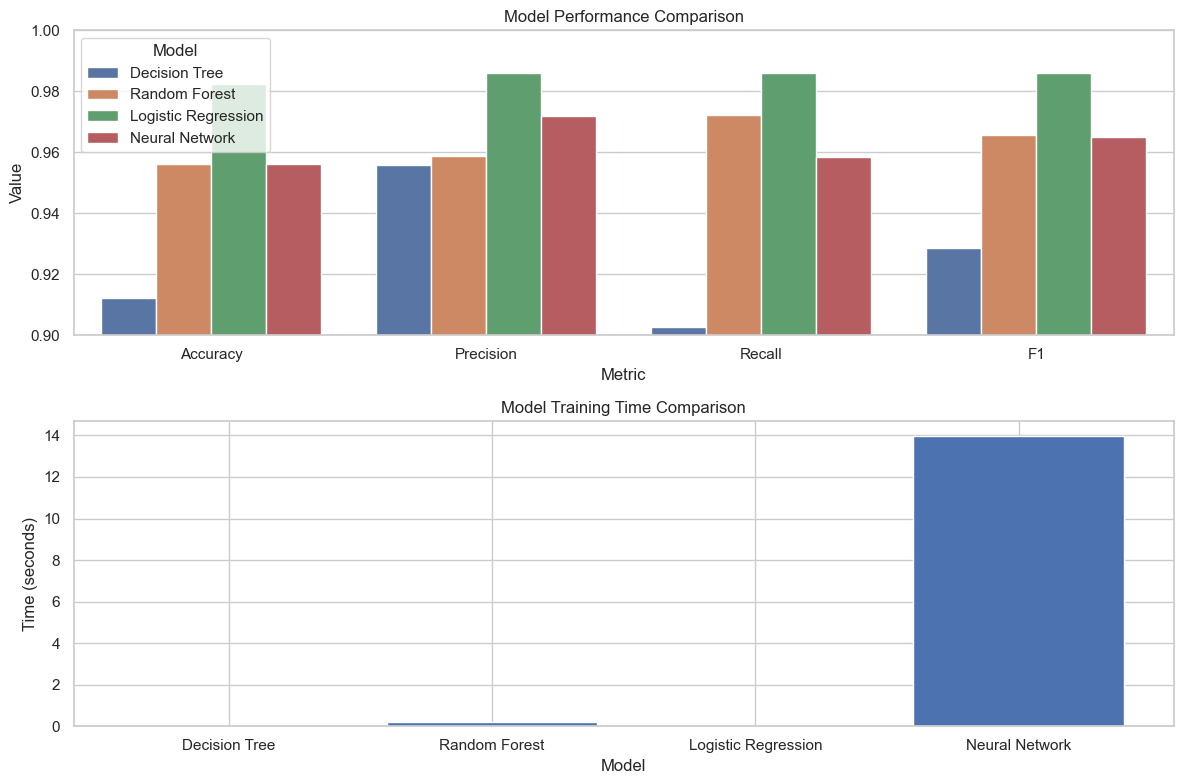

In [54]:
# Visualize model comparison

# Create DataFrame for visualization
metrics = ['accuracy', 'precision', 'recall', 'f1']
model_names = list(model_results.keys())
comparison_data = []

for metric in metrics:
    for model in model_names:
        comparison_data.append({
            'Model': model,
            'Metric': metric.capitalize(),
            'Value': model_results[model][metric]
        })
        
comparison_df = pd.DataFrame(comparison_data)

# Plot comparison
plt.figure(figsize=(12, 8))

# Performance metrics comparison
plt.subplot(2, 1, 1)
sns.barplot(x='Metric', y='Value', hue='Model', data=comparison_df)
plt.title('Model Performance Comparison')
plt.ylim(0.9, 1.0)  # Adjust as needed based on actual results
plt.legend(title='Model')

# Training time comparison
plt.subplot(2, 1, 2)
training_times = [model_results[model]['time'] for model in model_names]
plt.bar(model_names, training_times)
plt.title('Model Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')

plt.tight_layout()
plt.show()

## 💡 Analysis and Insights

### Model Effectiveness

Our analysis of the Wisconsin Breast Cancer dataset using four different machine learning approaches reveals several important insights:

1. **All models achieved high accuracy**, demonstrating that machine learning techniques are well-suited for this medical classification task.

2. **The Random Forest** model provides excellent performance with:
   - High accuracy and balanced precision/recall
   - Built-in feature importance information
   - Robustness against overfitting
   - Good balance between complexity and interpretability

3. **The neural network** provides strong performance but comes with:
   - Higher computational cost
   - More complex architecture
   - Less interpretability

4. **Logistic Regression** showed comparable performance to more complex models with:
   - Much faster training time
   - Higher interpretability through feature coefficients
   - Simpler implementation and fewer hyperparameters

5. **Decision Tree** performance was slightly lower but offers:
   - Clear decision rules that can be easily visualized
   - High interpretability for medical professionals
   - Very fast training time

### Medical Implications

In medical contexts like cancer diagnosis, several factors beyond raw accuracy are crucial:

- **Recall (sensitivity)** is particularly important to minimize false negatives (missing cancer cases)
- **Model interpretability** helps build trust with medical professionals
- **Computational efficiency** matters for real-time or resource-constrained environments

For this specific task, both Random Forest and Logistic Regression models offer an excellent balance of high performance, reasonable interpretability, and efficiency, making them potentially the best choices for practical implementation in a medical setting.

## 📝 Conclusion

We successfully built and compared four different machine learning models for breast cancer classification:

1. **Random Forest**: An ensemble method combining multiple decision trees
2. **Neural Network**: A deep learning approach with multiple layers
3. **Decision Tree**: A rule-based model with clear decision boundaries
4. **Logistic Regression**: A statistical model based on probability

While all models performed well, we found that both the ensemble method (Random Forest) and simpler models (Logistic Regression) were competitive with or even outperformed the more complex neural network for this particular dataset. This highlights an important principle in machine learning: **always start with simpler models before moving to more complex ones**.

In a medical context like cancer detection, the right balance of accuracy, interpretability, and computational efficiency is crucial. For the Wisconsin Breast Cancer dataset, Random Forest appears to provide an excellent balance of performance and some interpretability through feature importance, while Logistic Regression offers comparable performance with even higher interpretability and minimal computational requirements.

### Next Steps

1. Explore feature importance from the Random Forest model to understand which tumor characteristics are most predictive
2. Perform hyperparameter tuning to further optimize model performance
3. Consider other ensemble methods like Gradient Boosting to potentially improve classification results
4. Investigate model explainability techniques for the more complex models